<a href="https://colab.research.google.com/github/wendihexi/EE344_final_project/blob/main/Final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## One-Time Setup (Run Once)
Installs the packages<br>
Imports<br>
Sets global settings

In [ ]:
#Installing
!pip install yfinance prophet tqdm

In [ ]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

In [ ]:
#Global Settings
START_DATE = '1999-01-01'
split_date = '2023-01-01'

results = {}


## Data Loading and Shared Dataframes (Run Once)<br>
Loads data (including the regressors used in later models)<br>
sets up the base prophet datafram

In [ ]:
# load data
nvda = yf.download('NVDA', start=START_DATE, auto_adjust=True)
spy  = yf.download('SPY', start=START_DATE)
vix  = yf.download('^VIX', start=START_DATE)

# Clean columns
nvda = nvda.reset_index()
spy  = spy.reset_index()
vix  = vix.reset_index()

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1106775054.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy  = yf.download('SPY', start=START_DATE)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1106775054.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix  = yf.download('^VIX', start=START_DATE)
[*********************100%***********************]  1 of 1 completed


## Shared setup<br>
Build prophet<br>
prophet R^2<br>
plot prophet <br>
The goal of this code section is to reduce redunancy of the models and ensure an even playign field so to speak


In [ ]:
def build_prophet_df(nvda_df):
    """
    preprocessing logic
    """
    df = nvda_df.copy()

    # Flatten MultiIndex if needed
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Reset index once
    if 'Date' not in df.columns:
        df = df.reset_index()

    df = df[['Date', 'Close']].rename(
        columns={'Date': 'ds', 'Close': 'y'}
    )

    df['ds'] = pd.to_datetime(df['ds'])
    df['y'] = pd.to_numeric(df['y'], errors='coerce')
    df.dropna(inplace=True)

    return df


In [ ]:
def prophet_r2(test_df, forecast_df):
    """
    Compute R² safely after merging.
    """
    comparison = test_df.merge(
        forecast_df[['ds', 'yhat']],
        on='ds',
        how='inner'
    )
    return r2_score(comparison['y'], comparison['yhat'])


In [ ]:
def plot_prophet(prophet_df, forecast_df, split_date, title, label):
    """
    Plots the entire history, shows the split date, and highlights the forecast.
    """
    plt.figure(figsize=(14, 6))

    plt.plot(
        prophet_df['ds'],
        prophet_df['y'],
        label='Actual NVDA Price',
        color='black'
    )

    plt.plot(
        forecast_df['ds'],
        forecast_df['yhat'],
        linestyle='--',
        label=label
    )

    if {'yhat_lower', 'yhat_upper'}.issubset(forecast_df.columns):
        plt.fill_between(
            forecast_df['ds'],
            forecast_df['yhat_lower'],
            forecast_df['yhat_upper'],
            alpha=0.2,
            label='Confidence Interval'
        )

    plt.axvline(
        pd.to_datetime(split_date),
        color='red',
        linestyle=':',
        label='Train/Test Split'
    )

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_prophet_test_only(test_df, forecast_df, title, label):
    """
    Zoomed-in plot showing only the test period.
    """
    merged = test_df.merge(
        forecast_df[['ds', 'yhat']],
        on='ds',
        how='inner'
    )

    plt.figure(figsize=(14, 5))

    plt.plot(
        merged['ds'],
        merged['y'],
        label='Actual NVDA Price',
        color='black'
    )

    plt.plot(
        merged['ds'],
        merged['yhat'],
        linestyle='--',
        label=label
    )

    plt.title(title + ' (Test Period Only)')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()


# Baseline Prophet Model
Minimal data processing and using the base Prophet model without alterations

In [ ]:
# Build base dataframe
prophet_df = build_prophet_df(nvda)

# Train/Test split
train_df = prophet_df[prophet_df['ds'] < split_date]
test_df  = prophet_df[prophet_df['ds'] >= split_date]

# Model
baseline_model = Prophet()
baseline_model.fit(train_df)

# Forecast
future = baseline_model.make_future_dataframe(periods=len(test_df))
forecast_base = baseline_model.predict(future)

forecast_base = forecast_base[['ds','yhat','yhat_lower','yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


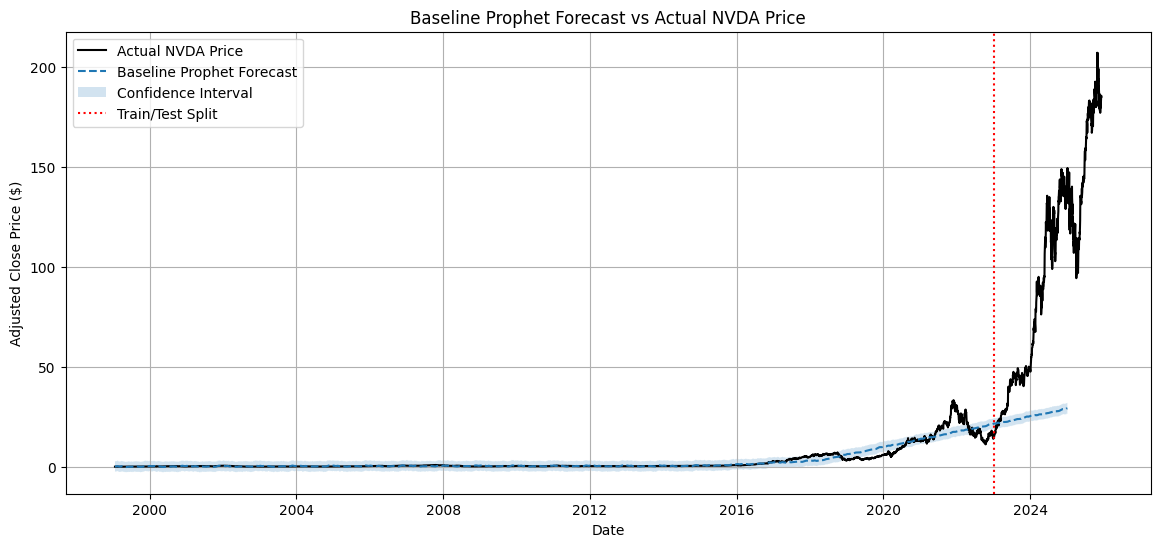

In [ ]:

# Plot
plot_prophet(
    prophet_df,
    forecast_base,
    split_date,
    'Baseline Prophet Forecast vs Actual NVDA Price',
    'Baseline Prophet Forecast'
)

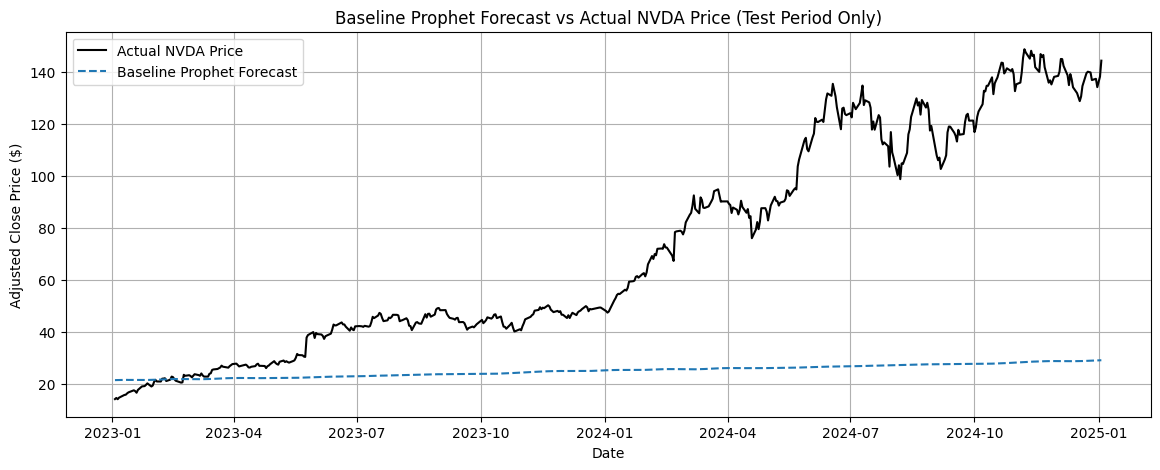

In [ ]:
plot_prophet_test_only(
    test_df,
    forecast_base,
    'Baseline Prophet Forecast vs Actual NVDA Price',
    'Baseline Prophet Forecast'
)

In [ ]:
# R²
r2 = prophet_r2(test_df, forecast_base)
print(f"Baseline Prophet R² score: {r2:.4f}")

Baseline Prophet R² score: -1.2213


In [ ]:
# Save the results for later comparison
results['Baseline Prophet'] = {
    'r2': r2,
    'forecast': forecast_base
}

The baseline Prophet model produced a negative out-of-sample R² score, indicating that it underperformed a naive mean predictor when forecasting NVDA’s daily adjusted closing prices. This result highlights the difficulty of predicting equity price levels in the presence of regime shifts and news-driven volatility. Prophet’s trend-smoothing assumptions limit its ability to extrapolate rapid structural changes, particularly during periods of explosive growth.<br><br>

This means that the next step would be trying to reduce how much Prophet tries to smooth the data and make it more flexible towards changes.

# Log and Flexible Trend Model<br>
Log-transform prices help stablize variance which should improve the R^2 score <br>
Flexible trends should help the model adapt better the changes in NVIDIA stock


In [ ]:
prophet_log_df = build_prophet_df(nvda)
prophet_log_df['y'] = np.log(prophet_log_df['y'])

train_log_df = prophet_log_df[prophet_log_df['ds'] < split_date]
test_log_df  = prophet_log_df[prophet_log_df['ds'] >= split_date]

improved_model = Prophet(changepoint_prior_scale=0.25)
improved_model.fit(train_log_df)

future_log = improved_model.make_future_dataframe(periods=len(test_log_df))
forecast_log = improved_model.predict(future_log)

forecast_log[['yhat','yhat_lower','yhat_upper']] = np.exp(
    forecast_log[['yhat','yhat_lower','yhat_upper']]
)

forecast_log = forecast_log[['ds','yhat','yhat_lower','yhat_upper']]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


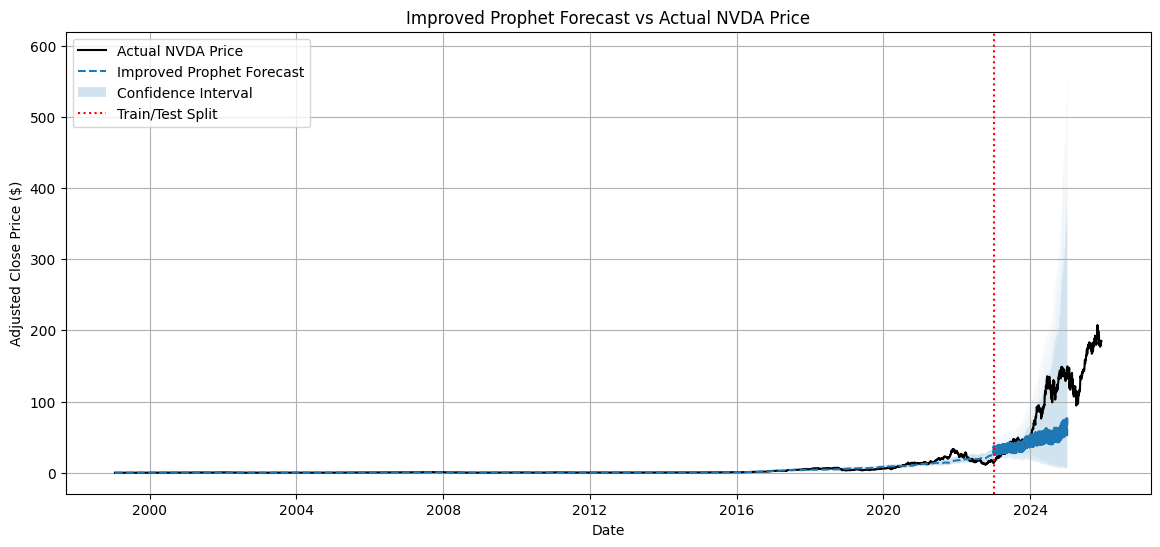

In [ ]:
plot_prophet(
    build_prophet_df(nvda),
    forecast_log,
    split_date,
    'Improved Prophet Forecast vs Actual NVDA Price',
    'Improved Prophet Forecast'
)

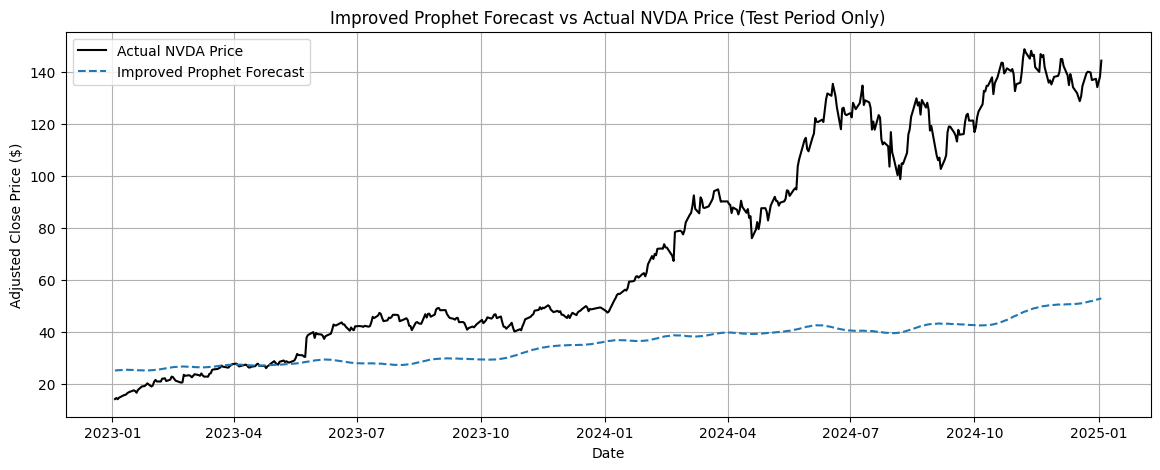

In [ ]:
plot_prophet_test_only(
    test_log_df.assign(y=np.exp(test_log_df['y'])),
    forecast_log,
    'Improved Prophet Forecast vs Actual NVDA Price',
    'Improved Prophet Forecast'
)


In [ ]:
r2_log = prophet_r2(
    build_prophet_df(nvda)[build_prophet_df(nvda)['ds'] >= split_date],
    forecast_log
)
print(f"Improved Prophet (Log + Flexible Trend) R²: {r2_log:.4f}")

# Improved Prophet (Log + Flexible Trend)
# When Changepoint = 0.15 -> R²: -0.5152, Its still bad, but it is in fact slightly better
# When Changepoint = 0.25 -> R²: -0.4935,
# When Changepoint = 0.50 -> R²: -0.4789,
# When Changepoint = 1.00 -> R²: -0.4727,

Improved Prophet (Log + Flexible Trend) R²: -0.4915


In [ ]:
# Save the results for later comparison
results['Flexible + Log Prophet'] = {
    'r2': r2_log,
    'forecast': forecast_log
}

The changepoint prior scale was varied to evaluate the effect of increased trend flexibility on out-of-sample performance. As the changepoint prior scale increased from 0.15 to 1.00, the R² score improved from −0.5152 to −0.4727. This indicates that allowing the model to respond more aggressively to structural changes in the trend partially mitigates Prophet’s tendency to underfit NVDA’s rapid growth during the test period.

However, despite the improvement, all configurations yielded negative R² scores, indicating that even the most flexible models still underperformed a naive mean predictor.

Although the highest R² was achieved at changepoint_prior_scale = 1.00, this value introduces a substantial risk of overfitting and produces highly unstable trend extrapolations. As a result, it is not appropriate as a foundation for more complex models, especially when considering the reduced improvedments going from 0.5 to 1.0 or 0.25 to 0.5.

Based on the changepoint sensitivity analysis, a changepoint prior scale of 0.25 was selected as the foundation for subsequent models. This value improved forecast performance relative to the baseline while maintaining reasonable trend stability and limiting overfitting.

# Enhanced Seasonality Model
Keeps log transform (stabilizes variance)

Keeps changepoint flexibility

Explicitly enables weekly & yearly seasonality

In [ ]:
prophet_season_df = build_prophet_df(nvda)
prophet_season_df['y'] = np.log(prophet_season_df['y'])

train_season_df = prophet_season_df[prophet_season_df['ds'] < split_date]
test_season_df  = prophet_season_df[prophet_season_df['ds'] >= split_date]

complex_model = Prophet(
    daily_seasonality =False, # this reduces the console messages
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.25,
    changepoint_range=0.8
)

complex_model.add_seasonality('monthly', 30.5, 5)
complex_model.fit(train_season_df)

future = complex_model.make_future_dataframe(periods=len(test_season_df))
forecast_season = complex_model.predict(future)

forecast_season[['yhat','yhat_lower','yhat_upper']] = np.exp(
    forecast_season[['yhat','yhat_lower','yhat_upper']]
)

forecast_season = forecast_season[['ds','yhat','yhat_lower','yhat_upper']]


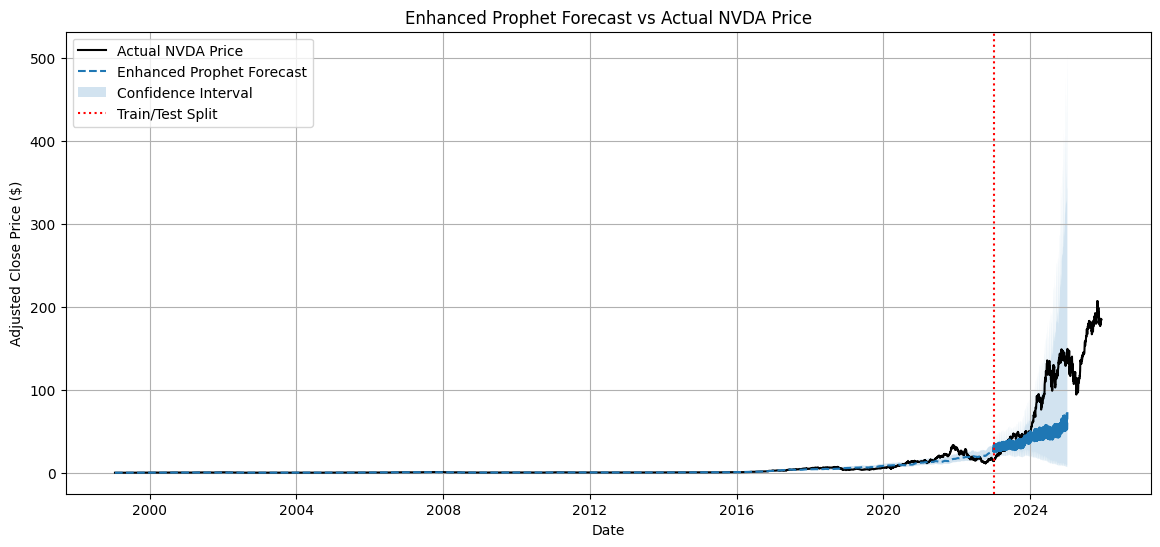

In [ ]:
plot_prophet(
    build_prophet_df(nvda),
    forecast_season,
    split_date,
    'Enhanced Prophet Forecast vs Actual NVDA Price',
    'Enhanced Prophet Forecast'
)

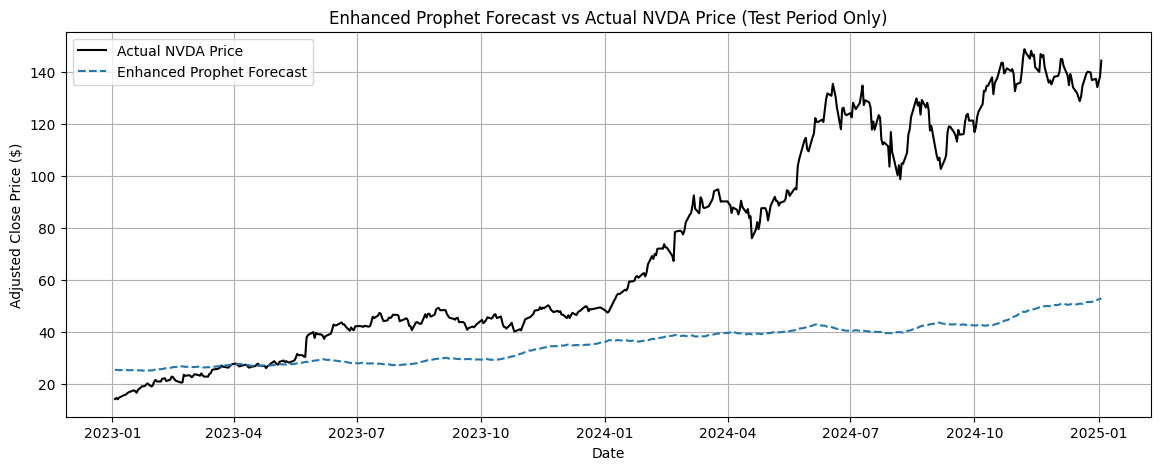

In [ ]:
plot_prophet_test_only(
    test_season_df.assign(y=np.exp(test_season_df['y'])),
    forecast_season,
    'Enhanced Prophet Forecast vs Actual NVDA Price',
    'Enhanced Prophet Forecast'
)

In [ ]:
r2_season = prophet_r2(
    build_prophet_df(nvda)[build_prophet_df(nvda)['ds'] >= split_date],
    forecast_season
)
print(f"Enhanced Prophet R²: {r2_season:.4f}")

Enhanced Prophet R²: -0.4945


In [ ]:
results['Seasonal Prophet'] = {
    'r2': r2_season,
    'forecast': forecast_season
}


It appears that adding seasonality has not made a significant difference, the graphs appear to remain similar to the previous model, and the R^2 score has stayed about the same. <br><br>
Going forward we will try other methods beyond seasonalilty.

# Rolling Forecast Implementation
Forecast one day ahead at each step. Add the actual point to the training set <br>
This came from after the presentation on Friday, the questions made us realize that we weren't adding the 'used' test values to the model which allowed the model's predictions to grow further and further away from the actual value. This should fix that.

In [ ]:

# Base dataframe
prophet_df = build_prophet_df(nvda)

# Train / Test split
split_date_rolling = '2018-01-01'
train_df = prophet_df[prophet_df['ds'] < split_date_rolling].copy()
test_df_roll  = prophet_df[prophet_df['ds'] >= split_date_rolling].copy()

# Rolling forecast
preds = []
train_temp = train_df.copy()

for i in tqdm(range(len(test_df_roll)), desc='Rolling Prophet (No Regressors)'):

    model = Prophet(
        daily_seasonality =False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25
    )

    model.fit(train_temp)

    future = test_df_roll[['ds']].iloc[[i]]
    forecast = model.predict(future)

    preds.append({
        'ds': test_df_roll.iloc[i]['ds'],
        'yhat': forecast['yhat'].iloc[0]
    })

    # add true observation
    train_temp = pd.concat(
        [train_temp, test_df_roll.iloc[[i]]],
        ignore_index=True
    )

forecast_roll_base = pd.DataFrame(preds)

Rolling Prophet (No Regressors):   0%|          | 0/1996 [00:00<?, ?it/s]

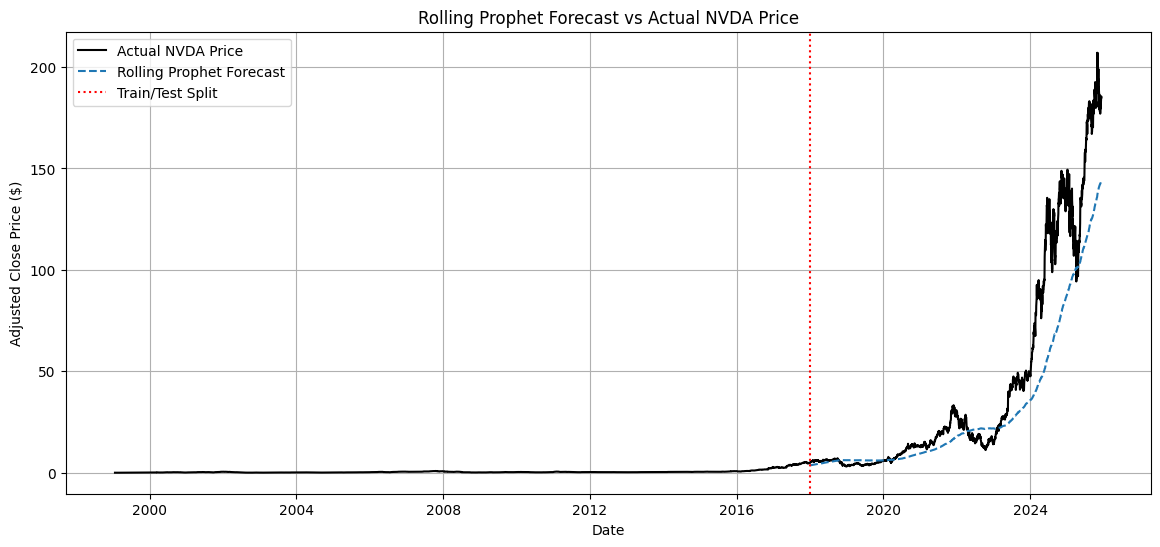

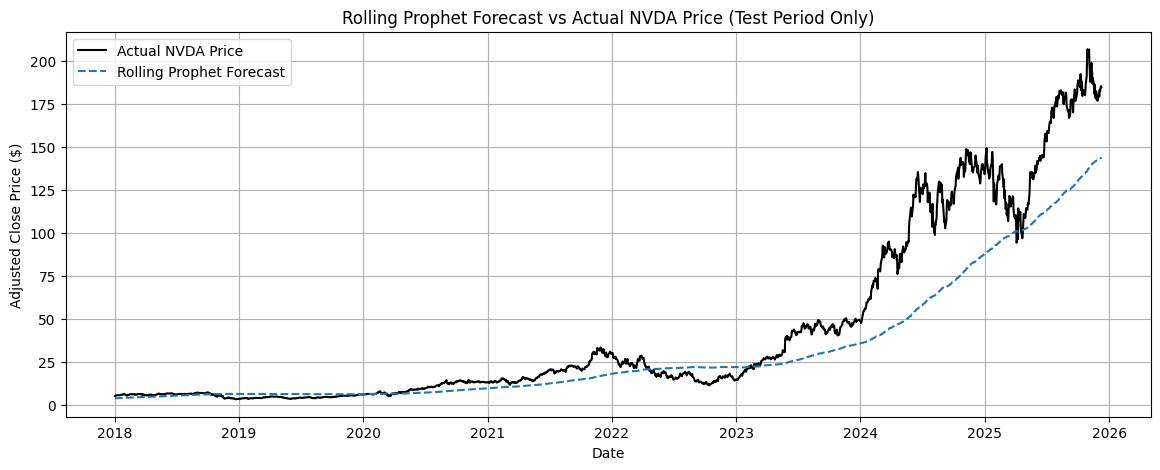

In [ ]:
plot_prophet(
    prophet_df,
    forecast_roll_base,
    split_date_rolling,
    'Rolling Prophet Forecast vs Actual NVDA Price',
    'Rolling Prophet Forecast'
)

plot_prophet_test_only(
    test_df_roll,
    forecast_roll_base,
    'Rolling Prophet Forecast vs Actual NVDA Price',
    'Rolling Prophet Forecast'
)


In [ ]:
# R²
r2_roll_base = r2_score(
    test_df_roll['y'],
    forecast_roll_base['yhat']
)

print(f"Rolling Prophet (No Regressors) R²: {r2_roll_base:.4f}")

Rolling Prophet (No Regressors) R²: 0.7974


In [ ]:
results['Rolling Prophet'] = {
    'r2': r2_roll_base,
    'forecast': forecast_roll_base
}


This is greatly improved the results. The predicted prices match the actual prices much closer on the plots and the R^2 score has signficantly increased, going from around -0.5 to +0.7. <br>
The next thing to explore is adding regressors to the prophet model to add further complexity and seeing how to additional information impacts the results.

# Adding Regressors (SPY and Volume)
Still using Rolling method and previous standards <br>
SPY -> helps capture general market trends <br>
Volume -> High trading volume may indicate price pressure <br>

Adding regressors allows prophet to take into account external factors. For a model trying to predict the Stock price which is something heavily impacted by external factors it should be helpful. <br>

Prophet fits a linear model for each regressot in addition to ites trend and seasonality, this allows the forecast to adjust depending on the values of the regressors

# Rolling Prophet (SPY + Volume + VIX)
adding VIX the volatility Index as an additional regressor <Br>

Given that Nvidia is an especially volatile dataset, this regressor may be able to add additional value.

In [ ]:
# Market index (SPY)
spy = yf.download('SPY', start='1999-01-01', auto_adjust=True)

# Volatility index (VIX)
vix = yf.download('^VIX', start='1999-01-01', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Build base Prophet dataframe
prophet_reg = build_prophet_df(nvda)   # columns: ds, y


# Prepare regressors with date column
spy_df = spy.reset_index()[['Date', 'Close']]
spy_df.columns = ['ds', 'SPY']

volume_df = nvda.reset_index()[['Date', 'Volume']]
volume_df.columns = ['ds', 'Volume']

vix_df = vix.reset_index()[['Date', 'Close']]
vix_df.columns = ['ds', 'VIX']


# Merge regressors by date
prophet_reg = prophet_reg.merge(spy_df, on='ds', how='left')
prophet_reg = prophet_reg.merge(volume_df, on='ds', how='left')
prophet_reg = prophet_reg.merge(vix_df, on='ds', how='left')



# Handle missing values
prophet_reg[['SPY','Volume','VIX']] = (
    prophet_reg[['SPY','Volume','VIX']]
    .ffill()
)


# Log-transform
for col in ['y', 'SPY', 'Volume', 'VIX']:
    prophet_reg[col] = np.log(prophet_reg[col].replace(0, np.nan))

prophet_reg.dropna(inplace=True)



# Train / Test split
train_df = prophet_reg[prophet_reg['ds'] < split_date_rolling].copy()
test_df  = prophet_reg[prophet_reg['ds'] >= split_date_rolling].copy()


# Rolling Forecast
preds = []
train_temp = train_df.copy()

for i in tqdm(range(len(test_df)), desc='Rolling Prophet (SPY + Volume + VIX)'):

    model = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.25
    )

    model.add_seasonality('monthly', period=30.5, fourier_order=5)
    model.add_regressor('SPY')
    model.add_regressor('Volume')
    model.add_regressor('VIX')

    model.fit(train_temp)

    future = test_df[['ds','SPY','Volume','VIX']].iloc[[i]]
    forecast = model.predict(future)

    preds.append({
        'ds': test_df.iloc[i]['ds'],
        'yhat': np.exp(forecast['yhat'].iloc[0])
    })

    # Expanding window
    train_temp = pd.concat(
        [train_temp, test_df.iloc[[i]]],
        ignore_index=True
    )


# Results
forecast_roll_all = pd.DataFrame(preds)

Rolling Prophet (SPY + Volume + VIX):   0%|          | 0/1996 [00:00<?, ?it/s]

In [ ]:
plot_prophet(
    prophet_reg.assign(y=np.exp(prophet_reg['y'])),
    forecast_roll_all,
    split_date_rolling,
    'Rolling Prophet Forecast vs Actual NVDA Price (SPY + Volume + VIX)',
    'Rolling Prophet Forecast'
)

plot_prophet_test_only(
    test_df.assign(y=np.exp(test_df['y'])),
    forecast_roll_all,
    'Rolling Prophet Forecast vs Actual NVDA Price (SPY + Volume + VIX)',
    'Rolling Prophet Forecast'
)

In [ ]:
# R²
r2_roll_all = r2_score(
    np.exp(test_df['y']),
    forecast_roll_all['yhat']
)

print(f"Rolling Prophet (SPY + Volume + VIX) R²: {r2_roll_all:.4f}")


In [ ]:
results['Rolling Prophet + Regressors'] = {
    'r2': r2_roll_all,
    'forecast': forecast_roll_all
}

# Naive Model
The naive model is the forecast is the previous value

In [ ]:
# Define train/test for Naive Model

# Train set: all dates before split
train_base = prophet_df[prophet_df['ds'] < split_date].copy()

# Test set: all dates on or after split
test_base = prophet_df[prophet_df['ds'] >= split_date].copy()

# Optional: reset index for easier handling
train_base = train_base.reset_index(drop=True)
test_base = test_base.reset_index(drop=True)

# Sanity check
print(f"Train size: {len(train_base)}, Test size: {len(test_base)}")
train_base.head()

Train size: 6026, Test size: 737


Price,ds,y
0,1999-01-22,0.037605
1,1999-01-25,0.041545
2,1999-01-26,0.038321
3,1999-01-27,0.038202
4,1999-01-28,0.038082


Naive Model R²: 0.9963


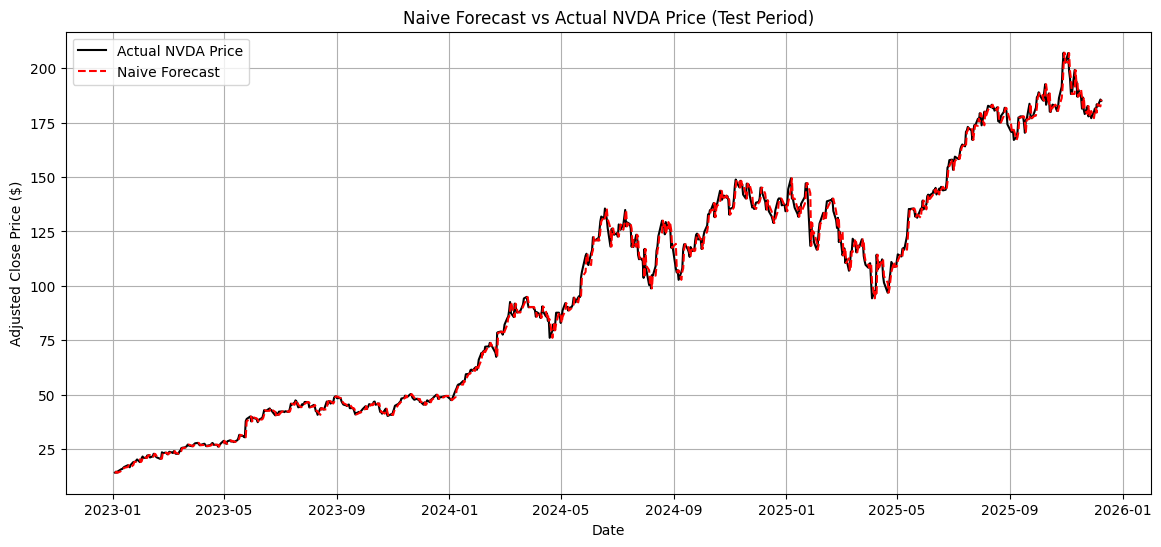

In [ ]:
# Naive Model (y_t = y_{t-1})

# Make a copy of the test_base
naive_forecast = test_base.copy()

# Shift actuals by 1 day to predict next day
# For the first day, we can just use the last value from training set
last_train_value = train_base['y'].iloc[-1]

# Create predictions
naive_preds = [last_train_value]  # first prediction

for i in range(len(test_base)-1):
    naive_preds.append(test_base['y'].iloc[i])

# Assign to dataframe
naive_forecast['yhat'] = naive_preds

# Compute R²
r2_naive = r2_score(test_base['y'].values, naive_forecast['yhat'].values)
print(f"Naive Model R²: {r2_naive:.4f}")


# Plot
plt.figure(figsize=(14,6))

# Actual prices
plt.plot(test_base['ds'], test_base['y'], color='black', label='Actual NVDA Price')

# Naive forecast
plt.plot(naive_forecast['ds'], naive_forecast['yhat'], linestyle='--', color='red', label='Naive Forecast')

plt.title("Naive Forecast vs Actual NVDA Price (Test Period)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
results['Naive Model'] = {
    'r2': r2_naive,
    'forecast': naive_forecast
}

# Model Comparison
A graphical comparison and a quantitative comparison

R² Scores for All Models:

                    Model  R² Score
0        Baseline Prophet -1.221264
1  Flexible + Log Prophet -0.491538
2         Rolling Prophet  0.797401
3             Naive Model  0.996256


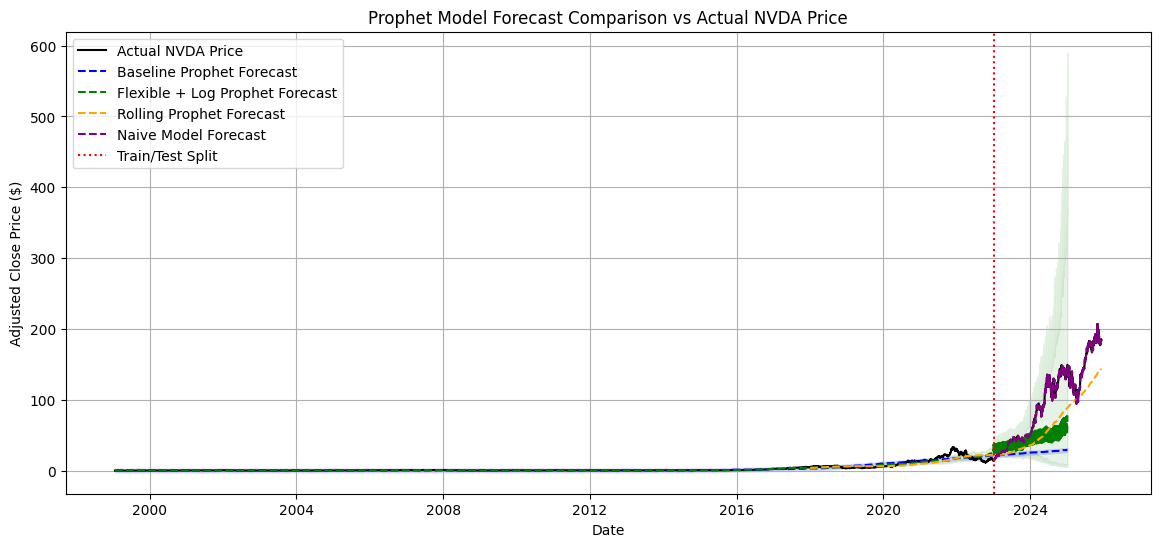

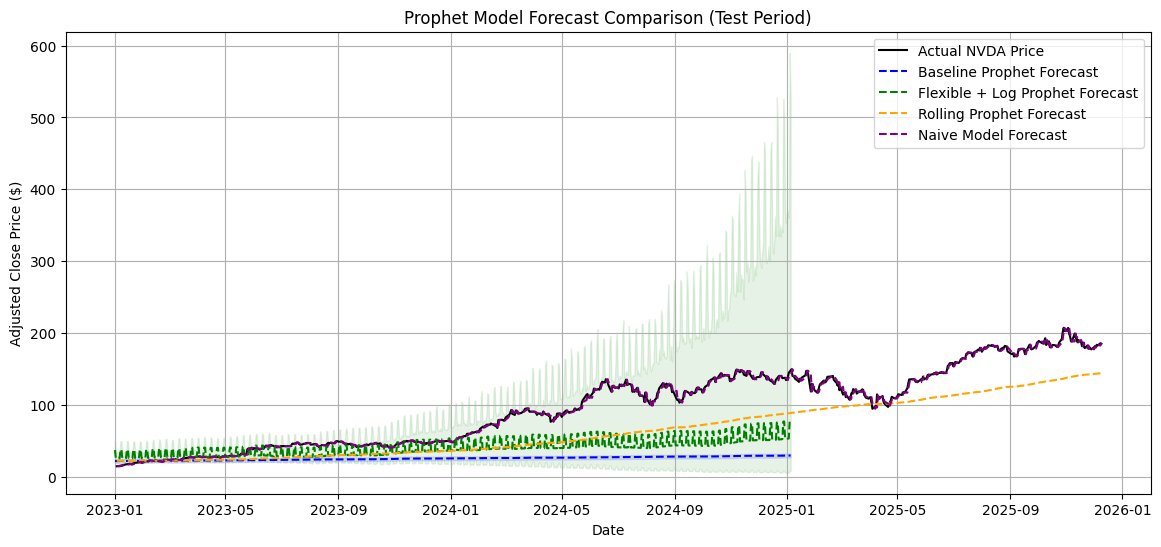

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# R² Comparison Table
# -----------------------------
r2_table = pd.DataFrame({
    'Model': list(results.keys()),
    'R² Score': [results[m]['r2'] for m in results]
})

print("R² Scores for All Models:\n")
print(r2_table)

# -----------------------------
# Colors for each model
# -----------------------------
colors = ['blue', 'green', 'orange', 'purple', 'brown', 'cyan']
color_map = {model: colors[i % len(colors)] for i, model in enumerate(results.keys())}

# -----------------------------
# Full History Plot
# -----------------------------
plt.figure(figsize=(14, 6))

# Plot actual NVDA prices
plt.plot(prophet_df['ds'], prophet_df['y'], color='black', label='Actual NVDA Price')

# Plot each model's forecast
for model_name, color in color_map.items():
    forecast = results[model_name]['forecast']
    plt.plot(forecast['ds'], forecast['yhat'], linestyle='--', color=color, label=f'{model_name} Forecast')

    # Optional: fill confidence interval if available
    if 'yhat_lower' in forecast.columns and 'yhat_upper' in forecast.columns:
        plt.fill_between(forecast['ds'],
                         forecast['yhat_lower'],
                         forecast['yhat_upper'],
                         alpha=0.1,
                         color=color)

# Train/test split line
plt.axvline(pd.to_datetime(split_date), color='red', linestyle=':', label='Train/Test Split')

plt.title('Prophet Model Forecast Comparison vs Actual NVDA Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Test Period Only Plot
# -----------------------------
plt.figure(figsize=(14, 6))

# Actual test prices
test_mask = prophet_df['ds'] >= split_date
plt.plot(prophet_df.loc[test_mask, 'ds'], prophet_df.loc[test_mask, 'y'],
         color='black', label='Actual NVDA Price')

# Each model forecast on test period
for model_name, color in color_map.items():
    forecast = results[model_name]['forecast']
    forecast_test = forecast[forecast['ds'] >= split_date]
    plt.plot(forecast_test['ds'], forecast_test['yhat'],
             linestyle='--', color=color, label=f'{model_name} Forecast')

    # Optional confidence interval
    if 'yhat_lower' in forecast_test.columns and 'yhat_upper' in forecast_test.columns:
        plt.fill_between(forecast_test['ds'],
                         forecast_test['yhat_lower'],
                         forecast_test['yhat_upper'],
                         alpha=0.1,
                         color=color)

plt.title('Prophet Model Forecast Comparison (Test Period)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')
plt.legend()
plt.grid(True)
plt.show()
